# 2. Capturing the uncertainty in multi-model climate projections with R2-D2

In this colab, we address the question: Can dynamical-generative downscaling provide a measure of uncertainty in downscaled climate projections similar to the more expensive dynamical downscaling approach? We focus on two sources of uncertainty here: the choice of forcing ESM, and internal variability. We do not examine scenario uncertainty or structural uncertainty in the dynamical downscaling process.

To answer this question, we use input coarse-resolution data from climate projections performed with an ensemble of Earth System Models (ESMs). We consider SSP3-7.0 climate projections of 8 ESMs from the Coupled Model Intercomparison Phase 6 (CMIP6). These models are described in Lopez-Gomez et al ([2024](https://doi.org/10.48550/arXiv.2410.01776)). The original climate projections, as well as corresponding downscaled projections over the western United States using WRF, are described in Rahimi et al ([2024](https://doi.org/10.5194/gmd-17-2265-2024)). We consider one SSP3-7.0 projection from each model, for a total of 8 projections.

We downscale this multi-model ensemble with both the Regional Residual Diffusion-based Downscaling (R2-D2) model and the dynamical downscaling model WRF. We treat dynamically downscaled WRF data as a sample from the true target distribution, as the R2-D2 model was trained to emulate this dynamical downscaling process.

This example colab focuses on multi-model climate projections for the winter period of December 2094 to February 2095, over the western United States domain defined in Lopez-Gomez et al. ([2024](https://doi.org/10.48550/arXiv.2410.01776)). This winter period falls outside the time range used to train R2-D2 with CanESM5 data. Data from all other ESMs also remains unseen by R2-D2. While this analysis focuses on a single end-of-century winter season, we use data from all ESMs, which are completely decorrelated after many decades of time integration. This gives us an effective sample size of one season multiplied by the number of ESMs in the ensemble.

# Selecting a runtime

The analysis in this Colab does not leverage TPU/GPU accelerators, so any of the freely available runtimes can be chosen. To run on CPU:

- Navigate to the menu item `Runtime` → `Change runtime type`.
- Select `CPU` and click `Save`.
- Click on `Connect` on the top right. You are ready once you see  `✓` next to the RAM & Disk display.

# Install dependencies

In [ ]:
!pip install zarr==2.18 matplotlib xarray gcsfs
!pip install git+https://github.com/google-research/swirl-dynamics.git@main

# Imports

We start by importing the required python libraries.

In [ ]:
import os
from typing import Literal

import gcsfs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

gcs = gcsfs.GCSFileSystem(token='anon')

# Load pre-generated downscaled samples, input data, and corresponding WRF data

We analyze the distribution of pre-generated downscaled samples from R2-D2. Generation of new samples with a pre-trained R2-D2 model is explored in the accompanying Colab `OS_downscaling_inference.ipynb` *(1. Probabilistic downscaling of climate data over the western US with R2-D2)*. Users who seek to analyze newly generated samples can combine the instructions in both colabs to do so.

We load the time-aligned coarse and high resolution WRF data from the WUS-D3 dataset. The high-resolution WRF data represents a sample of the true reference for the distribution of the downscaled results. The coarse-resolution data was used as the conditioning input to generate the provided R2-D2 samples.

We select daily snapshots at 00 UTC from the full 8-model ensemble described in Lopez-Gomez et al ([2024](
https://doi.org/10.48550/arXiv.2410.01776)), for the period December 2094 - February 2095. All 8 climate model projections follow the SSP3-7.0 forcing scenario. For each conditioning input, 32 generative high-resolution samples from R2-D2 are provided.

A function to fetch the multi-model ensemble from the Google Cloud Storage bucket is provided below.

In [ ]:
def _get_multimodel_ensemble(source: Literal['R2-D2', 'ESM', 'WRF'], subsampling_freq=8, sub_ensemble=False) -> xr.Dataset:
  """Returns a multi-model ensemble of weather snapshots given a data source.

  Args:
    source: The source of the data to fetch the multi-model ensemble from.
    subsampling_freq: Subsampling frequency of the R2-D2 32-member ensemble, to speed up computation.
    sub_ensemble: If True, returns a 4-model ensemble, instead of the 8-model ensemble. This
      significantly speeds up the quantile computation.

  Returns:
    A lazily loaded xarray.Dataset containing the requested multi-model ensemble.
  """
  # Google Cloud Storage directory
  GCS_DIR='gs://dynamical_generative_downscaling'

  # Paths to pre-generated samples
  inference_dir = os.path.join(GCS_DIR, 'inference_examples')

  isel_kwarg = {}
  # This option returns a multi-model ensemble downscaled with R2-D2.
  if source == 'R2-D2':
    suffix = 'inference'
    isel_kwarg = {'sample': slice(None, None, subsampling_freq)}
  # This option returns the coarse multi-model ensemble interpolated to fine-resolution.
  elif source == 'ESM':
    suffix = 'input'
  # This option returns a multi-model ensemble downscaled with WRF.
  elif source == 'WRF':
    suffix = 'target'

  access_ds = xr.open_zarr(gcs.get_mapper(os.path.join(inference_dir, f'access-cm2_r5i1p1f1_ssp370_bc_2094-12-01_to_2095-02-28_{suffix}.zarr'))).isel(**isel_kwarg)
  miroc_ds = xr.open_zarr(gcs.get_mapper(os.path.join(inference_dir, f'miroc6_r1i1p1f1_ssp370_bc_2094-12-01_to_2095-02-28_{suffix}.zarr'))).isel(**isel_kwarg)
  ukesm_ds = xr.open_zarr(gcs.get_mapper(os.path.join(inference_dir, f'ukesm1-0-ll_r2i1p1f2_ssp370_bc_2094-12-01_to_2095-02-28_{suffix}.zarr'))).isel(**isel_kwarg)
  ecearth_ds = xr.open_zarr(gcs.get_mapper(os.path.join(inference_dir, f'ec-earth3-veg_r1i1p1f1_ssp370_bc_2094-12-01_to_2095-02-28_{suffix}.zarr'))).isel(**isel_kwarg)
  canesm_ds = xr.open_zarr(gcs.get_mapper(os.path.join(inference_dir, f'canesm5_r1i1p2f1_ssp370_bc_2094-12-01_to_2095-02-28_{suffix}.zarr'))).isel(**isel_kwarg)
  taiesm_ds = xr.open_zarr(gcs.get_mapper(os.path.join(inference_dir, f'taiesm1_r1i1p1f1_ssp370_bc_2094-12-01_to_2095-02-28_{suffix}.zarr'))).isel(**isel_kwarg)
  noresm_ds = xr.open_zarr(gcs.get_mapper(os.path.join(inference_dir, f'noresm2-mm_r1i1p1f1_ssp370_bc_2094-12-01_to_2095-02-28_{suffix}.zarr'))).isel(**isel_kwarg)
  mpiesm_ds = xr.open_zarr(gcs.get_mapper(os.path.join(inference_dir, f'mpi-esm1-2-hr_r7i1p1f1_ssp370_bc_2094-12-01_to_2095-02-28_{suffix}.zarr'))).isel(**isel_kwarg)

  model_list = [access_ds, miroc_ds, ukesm_ds, ecearth_ds]
  if not sub_ensemble:
    model_list.extend([canesm_ds, taiesm_ds, noresm_ds, mpiesm_ds])
  return xr.concat(model_list, dim='sample')

**Speeding up the analysis**

Loading downscaled projections form the full 8-model ensemble hosted in Google Cloud Storage can take a significant amount of time, on the order of an hour or longer.

To speed up the analysis, we dowload by default downscaled projections from a smaller sub-ensemble comprised of 4 ESMs. For the same reason, we also restrict the download of R2-D2 samples to 4 samples per date, instead of the 32 available on Google Cloud. With the default configuration, the download should take less than 20 minutes. For those interested, the full data can be downloaded by setting `sub_ensemble=False`, and `subsampling_freq=1` below.

In [ ]:
# Change this to false to download the entire 8-model ensemble.
sub_ensemble = True
# Change this to 1 to download all provided R2-D2 samples.
subsampling_freq = 8

location = dict(south_north=slice(85, 340-85), west_east=slice(50, 270-50))
fields = ['T2', 'RAIN_24h', 'WINDSPEED10']

# Load R2-D2 generated data from all forcing ESMs
r2d2_multimodel_ds = _get_multimodel_ensemble(
    'R2-D2', sub_ensemble=sub_ensemble, subsampling_freq=subsampling_freq).isel(**location).get(fields).compute()

# Load conditioning inputs: Time-aligned coarse-resolution climate data
input_multimodel_ds = _get_multimodel_ensemble(
    'ESM', sub_ensemble=sub_ensemble, subsampling_freq=subsampling_freq).isel(**location).get(fields).compute()

# Load WRF-based dynamically downscaled samples for the same dates
target_multimodel_ds = _get_multimodel_ensemble(
    'WRF', sub_ensemble=sub_ensemble, subsampling_freq=subsampling_freq).isel(**location).get(fields).compute()

#  Spatial distribution of quantiles of the generative and dynamically downscaled ensembles

We compare the spread of the R2-D2 and WRF downscaled multi-model projections by examining their quantiles. We compare the distributions at a selected quantile level, such as `q=0.9`. We also include the interpolated coarse-resolution data to demonstrate the added value of downscaling with respect to the input climate data.

The spatial distribution of the requested quantile is shown below for different meteorological fields. Results are shown for the R2-D2 model, the input ESM interpolated to the high-resolution grid, and the reference WRF data (i.e., the target). Land contours are highlighted in black for reference.

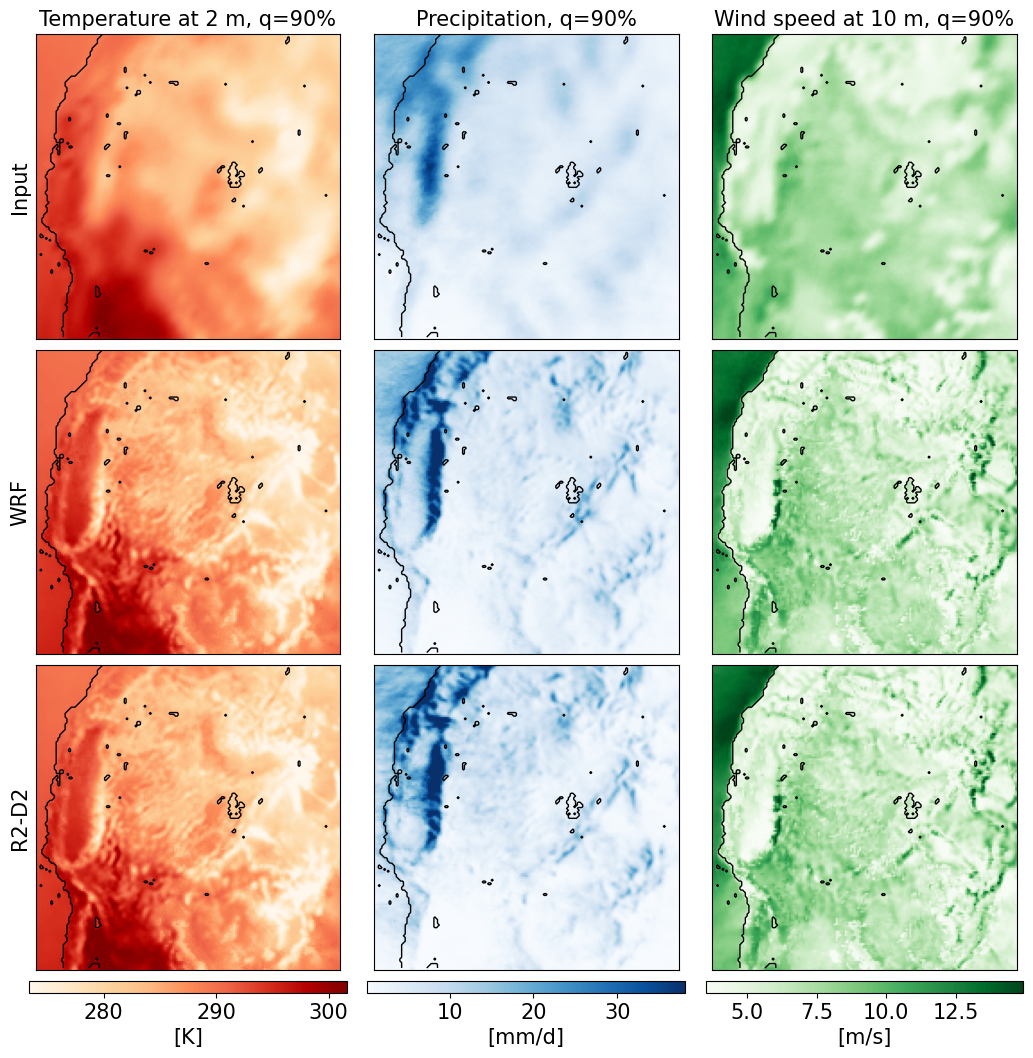

In [ ]:
# Modify this to inspect other quantiles, in the open interval (0, 1).
q = 0.9 # Very extreme quantiles will have larger sampling error.

# We aggregate samples from all climate models and days within the evaluation period.
agg_dims = ['time', 'sample']
r2d2_q_ds = r2d2_multimodel_ds.quantile(q, dim=agg_dims).compute()
input_q_ds = input_multimodel_ds.quantile(q, dim=agg_dims).compute()
target_q_ds = target_multimodel_ds.quantile(q, dim=agg_dims).compute()

## Load the land-sea mask to highlight land contours
static_input_path = 'gs://dynamical_generative_downscaling/wrf-coordinates/wrfinput_d02.zarr'
static_ds = xr.open_zarr(gcs.get_mapper(static_input_path)).isel(south_north=slice(85, 340-85), west_east=slice(50, 270-50))
land_cutoff = [0.5]
landmask = static_ds['LANDMASK']

# Units and figure annotations
units_dict = {'T2': 'K', 'RAIN_24h': 'mm/d', 'WINDSPEED10': 'm/s'}
nice_varnames = {'T2': 'Temperature at 2 m', 'RAIN_24h': 'Precipitation', 'WINDSPEED10': 'Wind speed at 10 m'}
fontsize = 15

# Create figure and set panel sizes
num_fields = len(fields)
# Number of plots for each field: R2-D2 samples, input data, and WRF downscaled data
num_column_plots = 3
height_ratios = [25] * (num_fields+1)
height_ratios[-1] = 1
fig, ax = plt.subplots(num_column_plots+1, num_fields, figsize=(3.5*num_fields,
                       3.5*(num_column_plots+1/height_ratios[0])), gridspec_kw={'height_ratios': height_ratios})

# Plot results for each field
for field_id, field in enumerate(fields):

  # Get field from input, WRF, and R2-D2
  input_field = input_q_ds[field]
  target_field = target_q_ds[field]
  samples_field = r2d2_q_ds[field]

  # Ensure common plotting range
  vmin = input_field.values.min()
  vmax = input_field.values.max()

  # Define colormaps for each field
  cmap = 'OrRd'
  if field =='RAIN_24h':
    cmap = 'Blues'
  elif field =='WINDSPEED10':
    cmap = 'Greens'

  imshow_kwargs = dict(origin='lower',  cmap=cmap)
  imshow_kwargs['vmin'] = vmin
  imshow_kwargs['vmax'] = vmax

  # Plot input
  im = ax[0, field_id].imshow(input_field, **imshow_kwargs)
  ax[0, field_id].contour(landmask, origin='lower', levels=land_cutoff, cmap='gist_gray', linewidths=1)
  ax[0, field_id].set_title(f'{nice_varnames[field]}, q={int(q*100)}%', size=fontsize)
  # Omit axes
  ax[0, field_id].set_xticks([])
  ax[0, field_id].set_yticks([])
  ax[0, 0].set_ylabel('Input', size=fontsize)

  # Plot target (WRF)
  im = ax[1, field_id].imshow(target_field, **imshow_kwargs)
  ax[1, field_id].contour(landmask, origin='lower', levels=land_cutoff, cmap='gist_gray', linewidths=1)
  # Omit axes
  ax[1, field_id].set_xticks([])
  ax[1, field_id].set_yticks([])
  ax[1, 0].set_ylabel('WRF', size=fontsize)

  # Plot R2-D2 samples
  im = ax[2, field_id].imshow(samples_field, **imshow_kwargs)
  ax[2, field_id].contour(landmask, origin='lower', levels=land_cutoff, cmap='gist_gray', linewidths=1)
  ax[2, 0].set_ylabel(f'R2-D2', size=fontsize)
  ax[2, field_id].set_xticks([])
  ax[2, field_id].set_yticks([])

  cbar = fig.colorbar(im, cax=ax[num_column_plots, field_id], orientation='horizontal')
  cbar.set_label(label=f'[{units_dict[field]}]', size=fontsize)
  cbar.ax.tick_params(labelsize=fontsize)

fig.subplots_adjust(wspace=0.12, hspace=0.05)
plt.tight_layout()

# Skill at quantifying uncertainty in multi-model climate projections

Here we evaluate the ability of R2-D2 downscaled projections to match those from WRF, in terms of the multi-model ensemble quantile tracking error. Particularly, we measure skill in terms of the mean absolute quantile error over land.

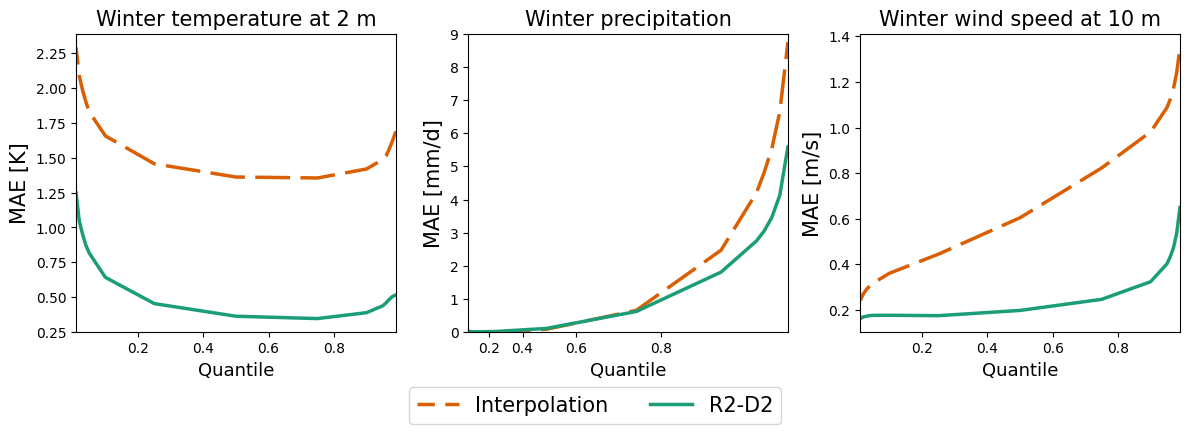

In [ ]:
# Fields considered
fields = ['T2', 'RAIN_24h', 'WINDSPEED10']

# Select quantiles to compute
quantiles = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

# Annotations and formatting
nice_title_dict = {
             'T2': 'Winter temperature at 2 m',
             'RAIN_24h': 'Winter precipitation',
             'WINDSPEED10': 'Winter wind speed at 10 m',
             }
nice_name_dict = {'RAIN_24h': 'Precipitation', 'T2': 'Temperature', 'WINDSPEED10': 'Wind speed'}
alpha=.2
linewidth=2.5
bar_colors_dict = {'Interpolation': '#D95F02', 'R2-D2': '#1B9E77'}
linestyle_dict = {'Interpolation': (5, (10, 3)), 'R2-D2': '-'}

def land_mae(ds, ds_ref):
  """Computes the mean absolute error between two datasets over land."""
  landmask = static_ds['LANDMASK'].values
  weights = landmask > 0.5
  abs_err = xr.apply_ufunc(np.fabs, (ds - ds_ref).load())
  num = xr.where(weights, abs_err, 0).sum(['south_north', 'west_east'])
  den = weights.sum()
  return num / den

# We aggregate samples from all climate models and days within the period
agg_dims = ['time', 'sample']
r2d2_q_ds = r2d2_multimodel_ds.quantile(quantiles, dim=agg_dims).compute()
input_q_ds = input_multimodel_ds.quantile(quantiles, dim=agg_dims).compute()
target_q_ds = target_multimodel_ds.quantile(quantiles, dim=agg_dims).compute()

fig, axs = plt.subplots(1, len(fields), figsize=(4*len(fields), 4))
for j, field in enumerate(fields):

  # Baseline
  interp_mae = land_mae(input_q_ds[field], target_q_ds[field])
  # Model
  r2d2_mae = land_mae(r2d2_q_ds[field], target_q_ds[field])

  axs[j].set_ylabel(f'MAE [{units_dict[field]}]', size=fontsize)
  axs[j].set_title(f'{nice_title_dict[field]}', size=fontsize)
  axs[j].plot(quantiles, interp_mae, label='Interpolation', color=bar_colors_dict['Interpolation'], linewidth=linewidth, linestyle=linestyle_dict['Interpolation'])
  axs[j].plot(quantiles, r2d2_mae, label='R2-D2', color=bar_colors_dict['R2-D2'], linewidth=linewidth, linestyle=linestyle_dict['R2-D2'])

  axs[j].set_xlim(0.01, 0.99)
  axs[j].set_xlabel('Quantile', size=fontsize-2)
  if field == 'RAIN_24h':
    axs[j].set_ylim(0., 9)
    # We scale the x-axis exponentially to separate out the extreme quantiles
    def forward(x):
        return 10**(x)
    def inverse(x):
        return np.log10(x)
    axs[j].set_xscale('function', functions=(forward, inverse))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=8, fancybox=True, ncol=4, bbox_to_anchor=(0.5, -0.1), fontsize=fontsize)
plt.tight_layout()
plt.show()

# Distribution of climate projections at a local scale

While previous figures analyzed the skill of R2-D2 at a regional level, here we examine its ability to match the target distribution at a local scale, by using Q-Q plots for specific locations in the western United States.

Our analysis focuses on three locations with markedly different climates: coastal Portland, Oregon; Bozeman, Montana, in the foothills of the Rocky Mountains; and Albuquerque, New Mexico, in the dry American Southwest.

To illustrate this, we consider downscaled projections from the full 8-model ensemble. Downloading the necessary data and computing the quantiles should take less than 10 minutes.

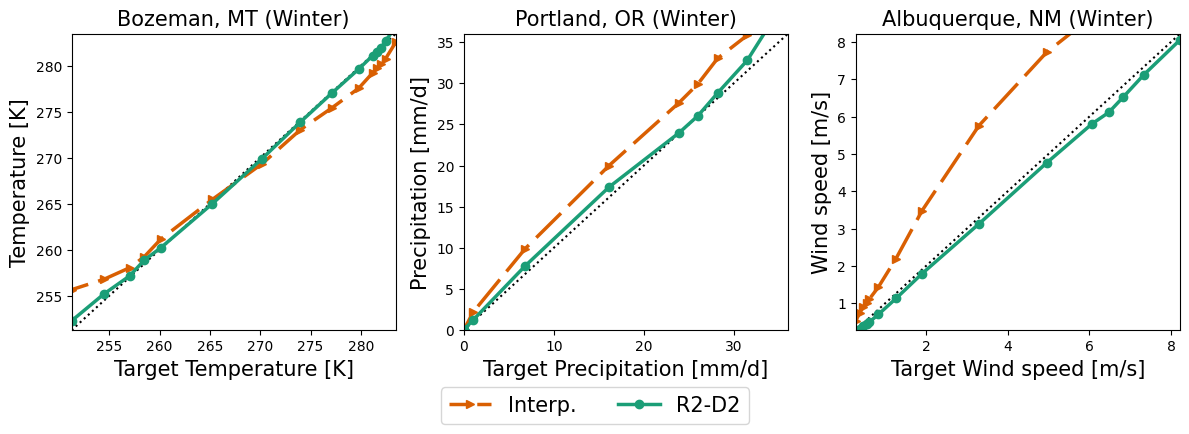

In [ ]:
# Fields considered
fields = ['T2', 'RAIN_24h', 'WINDSPEED10']

# Select locations
# # Bozeman
bozeman_lat = 45.7
bozeman_lon = -111

# # Portland
portland_lat = 45.5
portland_lon = -122.67

# # Albuquerque
albuquerque_lat = 35.1
albuquerque_lon = -106.6

def isel_around_loc(ds:xr.Dataset, lat:float, lon:float, halfwidth:float = 0.1) -> np.ndarray:
  """Returns a regional mask around a (lat, lon) location.

  Args:
    lat: The latitude about which to center the mask, in degrees.
    lon: The longitude about which to center the mask, in degrees.
    halfwidth: The spatial halfwidth of the mask, in degrees.

  Returns:
    The spatial mask.
  """
  static_ds = xr.open_zarr(gcs.get_mapper(static_input_path))
  lats = static_ds['XLAT']
  lons = static_ds['XLONG']
  dims = static_ds['XLAT'].dims
  mask_lat = np.logical_and(lats > lat - halfwidth, lats < lat + halfwidth)
  mask_lon = np.logical_and(lons > lon - halfwidth, lons < lon + halfwidth)
  mask = np.logical_and(mask_lon, mask_lat)
  loc_indices = np.where(mask)
  return ds.isel(**{dim: slice(np.min(loc_index), np.max(loc_index)+1) for loc_index, dim in zip(loc_indices, dims)})

# Select quantiles to compute
quantiles = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]
agg_dims = ['time', 'sample']

# Annotations and formatting
nice_title_dict = {
             'T2': 'Winter temperature at 2 m',
             'RAIN_24h': 'Winter precipitation',
             'WINDSPEED10': 'Winter wind speed at 10 m',
             }
location_dict = {
             'T2': 'Bozeman, MT (Winter)',
             'RAIN_24h': 'Portland, OR (Winter)',
             'WINDSPEED10': 'Albuquerque, NM (Winter)',
             }
nice_name_dict = {'RAIN_24h': 'Precipitation', 'T2': 'Temperature', 'WINDSPEED10': 'Wind speed'}
alpha=.2
linewidth=2.5
bar_colors_dict = {'Interpolation': '#D95F02', 'R2-D2': '#1B9E77'}
linestyle_dict = {'Interpolation': (5, (10, 3)), 'R2-D2': '-'}

# We mask locations with a halfwidth of 0.1 degrees
mask_dict = {'T2': (bozeman_lat, bozeman_lon,),
             'RAIN_24h': (portland_lat, portland_lon),
             'WINDSPEED10': (albuquerque_lat, albuquerque_lon),
             }

# Get full multi-model ensemble. Consider 8 R2-D2 samples per condition.
r2d2_multimodel_ds = _get_multimodel_ensemble('R2-D2', subsampling_freq=4)
input_multimodel_ds = _get_multimodel_ensemble('ESM')
target_multimodel_ds = _get_multimodel_ensemble('WRF')

fig, axs = plt.subplots(1, len(fields), figsize=(4*len(fields), 4))
for j, field in enumerate(fields):

  # Compute quantiles
  r2d2_quantiles_ds = isel_around_loc(r2d2_multimodel_ds.get([field]), *mask_dict[field]).chunk(dict(time=-1, sample=-1)).quantile(quantiles, dim=agg_dims)
  input_quantiles_ds = isel_around_loc(input_multimodel_ds.get([field]), *mask_dict[field]).chunk(dict(time=-1, sample=-1)).quantile(quantiles, dim=agg_dims)
  target_quantiles_ds = isel_around_loc(target_multimodel_ds.get([field]), *mask_dict[field]).chunk(dict(time=-1, sample=-1)).quantile(quantiles, dim=agg_dims)

  q_target_da = target_quantiles_ds[field].mean(['south_north', 'west_east']).compute()
  q_interp_da = input_quantiles_ds[field].mean(['south_north', 'west_east']).compute()
  q_r2d2_da = r2d2_quantiles_ds[field].mean(['south_north', 'west_east']).compute()

  axs[j].set_xlabel(f'Target {nice_name_dict[field]} [{units_dict[field]}]', size=fontsize)
  axs[j].set_ylabel(f'{nice_name_dict[field]} [{units_dict[field]}]', size=fontsize)
  axs[j].set_title(f'{location_dict[field]}', size=fontsize)

  axs[j].plot(q_target_da, q_target_da, color='k', linestyle=':')
  axs[j].plot(q_target_da, q_interp_da, linewidth=linewidth, marker='>', color=bar_colors_dict['Interpolation'], label='Interp.', linestyle=linestyle_dict['Interpolation'])
  axs[j].plot(q_target_da, q_r2d2_da, linewidth=linewidth, marker='o', color=bar_colors_dict['R2-D2'], label='R2-D2', linestyle=linestyle_dict['R2-D2'])

  axs[j].set_xlim(q_target_da.min(), q_target_da.max())
  axs[j].set_ylim(q_target_da.min(), q_target_da.max())

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=8, fancybox=True, ncol=4, bbox_to_anchor=(0.5, -0.1), fontsize=fontsize)
plt.tight_layout()
plt.show()